In [1]:
"""
Created on Fri Feb 21 14:46:00 2019

@author: alexandremendes

"""

'\nCreated on Fri Feb 21 14:46:00 2019\n\n@author: alexandremendes\n\n'

# Libraries

In [93]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import plotly
import io
import base64
import seaborn as sns
sns.set_style('white')

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer


from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from time import time

pd.set_option('display.max_columns', 100)

# Functions

In [3]:
def mutual_hist(data1, data1_name, data1_color, data2, data2_name, data2_color, x_label, y_label, title):
    """
    Plot overlaid histograms of two distributions
    """
    # Set the bounds for the bins so that the two distributions are fairly compared
    max_nbins = 10
    data_range = [min(min(data1), min(data2)), max(max(data1), max(data2))]
    binwidth = (data_range[1] - data_range[0]) / max_nbins
    bins = np.arange(data_range[0], data_range[1] + binwidth, binwidth)

    # Create the plot
    _, ax = plt.subplots()
    ax.hist(data1, bins = bins, color = data1_color, alpha = 1, label = data1_name)
    ax.hist(data2, bins = bins, color = data2_color, alpha = 0.75, label = data2_name)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)
    ax.legend(loc = 'best')

In [4]:
def classification_report(y_true, y_pred, name_classifiers, train_time=None):
    """
    Displays multiple evaluation metrics for each classifier
    """
    assert(len(y_pred) == len(name_classifiers))
    assert(len(train_time) == len(name_classifiers) if train_time else True)
    
    reports = []
    metrics = ["Classifier", "Accuracy", "Precision", "Recall", "F1-Score"]
    if train_time:
        metrics = metrics + ["Training Duration (seconds)"]

    for idx, y_clf in enumerate(y_pred):
        acc = accuracy_score(y_true, y_clf)
        pre = precision_score(y_true, y_clf)
        rec = recall_score(y_true, y_clf)
        f1s = f1_score(y_true, y_clf)
        report = (name_classifiers[idx], acc, pre, rec, f1s)
        if train_time:
            report = report + (train_time[idx], )
        reports.append(report)
            
    display(pd.DataFrame.from_records(reports, columns=metrics))

In [58]:
def fig_to_base64(fig):
    img = io.BytesIO()
    fig.savefig(img, format='png',
                bbox_inches='tight')
    img.seek(0)

    return base64.b64encode(img.getvalue())

# Data mining

In [5]:
df_atp = pd.read_csv('./ATP.csv', dtype=str)

In [6]:
# Create new columns storing year and year/month attributes
df_atp['tourney_yearmonth'] = df_atp.tourney_date.astype(str).str[:6]
df_atp['tourney_year'] = df_atp.tourney_date.astype(str).str[:4]

df_atp = df_atp[df_atp['tourney_year'].between('1968','2016')]

# Cast specific columns
df_atp['winner_rank'] = df_atp['winner_rank'].fillna(0).astype(int)
df_atp['loser_rank'] = df_atp['loser_rank'].fillna(0).astype(float)
df_atp['winner_age'] = df_atp['winner_age'].dropna().astype(float)
df_atp['loser_age'] = df_atp['loser_age'].dropna().astype(float)
df_atp['winner_ht'] = df_atp['winner_ht'].dropna().astype(int)
df_atp['loser_ht'] = df_atp['loser_ht'].dropna().astype(int)
df_atp['w_svpt'] = df_atp['w_svpt'].fillna(0).astype(int)
df_atp['l_svpt'] = df_atp['l_svpt'].fillna(0).astype(int)
df_atp['w_ace'] = df_atp['w_ace'].fillna(0).astype(int)
df_atp['l_ace'] = df_atp['l_ace'].fillna(0).astype(int)
df_atp['w_df'] = df_atp['w_df'].fillna(0).astype(int)
df_atp['l_df'] = df_atp['l_df'].fillna(0).astype(int)
df_atp['w_bpSaved'] = df_atp['w_bpSaved'].fillna(0).astype(int)
df_atp['l_bpSaved'] = df_atp['l_bpSaved'].fillna(0).astype(int)

In [7]:
df_atp.tourney_year = pd.to_numeric(df_atp.tourney_year, errors='coerce').fillna(0).astype(np.int64)
df_atp.tourney_date = pd.to_numeric(df_atp.tourney_date, errors='coerce').fillna(0).astype(np.int64)

In [8]:
df_atp.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,winner_rank,winner_rank_points,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,loser_rank,loser_rank_points,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,tourney_yearmonth,tourney_year
0,1968-580,Australian Chps.,Grass,64,G,19680119,001,110023,NaN,NaN,Richard Coulthard,R,NaN,AUS,NaN,0,NaN,107760,NaN,NaN,Max Senior,R,NaN,AUS,NaN,0.0,NaN,12-10 7-5 4-6 7-5,5,R64,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,196801,1968
1,1968-580,Australian Chps.,Grass,64,G,19680119,002,109803,NaN,NaN,John Brown,R,NaN,AUS,27.520876,0,NaN,106964,NaN,NaN,Ernie Mccabe,R,NaN,AUS,NaN,0.0,NaN,6-3 6-2 6-4,5,R64,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,196801,1968
2,1968-580,Australian Chps.,Grass,64,G,19680119,003,100257,NaN,NaN,Ross Case,R,NaN,AUS,16.216290,0,NaN,110024,15,NaN,Gondo Widjojo,R,NaN,INA,NaN,0.0,NaN,6-4 3-6 6-3 7-5,5,R64,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,196801,1968
3,1968-580,Australian Chps.,Grass,64,G,19680119,004,100105,5,NaN,Allan Stone,R,NaN,AUS,22.264203,0,NaN,110025,NaN,NaN,Robert Layton,R,NaN,AUS,NaN,0.0,NaN,6-4 6-2 6-1,5,R64,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,196801,1968
4,1968-580,Australian Chps.,Grass,64,G,19680119,005,109966,NaN,NaN,Warren Jacques,R,NaN,AUS,29.861739,0,NaN,110026,NaN,NaN,Bert Kearney,R,NaN,AUS,NaN,0.0,NaN,6-4 6-1 7-5,5,R64,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,0,0,0,NaN,NaN,NaN,NaN,0,NaN,196801,1968


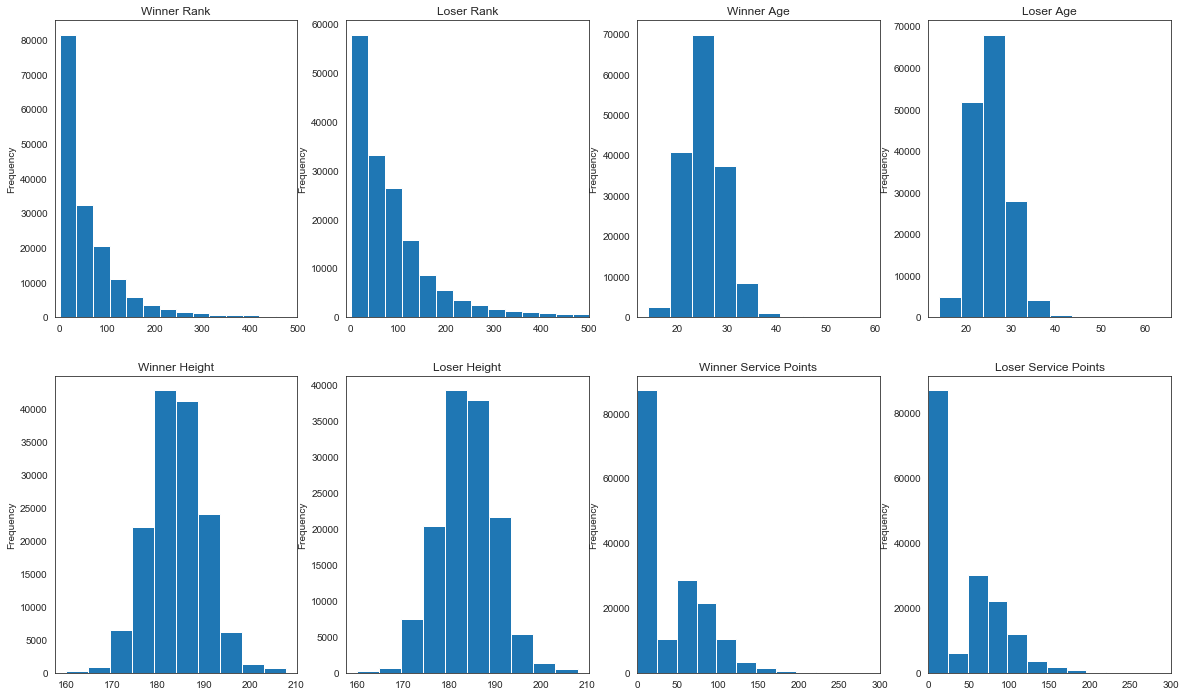

In [62]:
# Explore several parameters
plt.figure(1, figsize=(20,12))
plt.subplot(2,4,1)
df_atp['winner_rank'].plot(kind='hist',bins=60, xlim=(-10,500), title='Winner Rank')

plt.subplot(2,4,2)
df_atp['loser_rank'].plot(kind='hist',bins=60, xlim=(-10,500), title='Loser Rank')

plt.subplot(2,4,3)
df_atp['winner_age'].plot(kind='hist', title='Winner Age')

plt.subplot(2,4,4)
df_atp['loser_age'].plot(kind='hist', title='Loser Age')

plt.subplot(2,4,5)
df_atp['winner_ht'].plot(kind='hist', title='Winner Height')

plt.subplot(2,4,6)
df_atp['loser_ht'].plot(kind='hist', title='Loser Height')

plt.subplot(2,4,7)
df_atp['w_svpt'].plot(kind='hist', title='Winner Service Points', xlim=(0,300), bins=20)

plt.subplot(2,4,8)
df_atp['l_svpt'].plot(kind='hist', title='Loser Service Points', xlim=(0,300), bins=20)

plt.savefig('data_mining.png')

#plotly.offline.plot(fig, filename='data_mining.html')

# Random Forest

In [63]:
df_atp["Labels"] = df_atp.apply(lambda row: 1 if row["winner_name"] < row["loser_name"] else 0, axis=1)
display(df_atp[["winner_name", "loser_name", "Labels"]].head(5))

display(HTML("<h4>The number of 1's : {}".format(df_atp[df_atp["Labels"] == 1].shape[0])))
display(HTML("<h4>The number of 0's : {}".format(df_atp[df_atp["Labels"] == 0].shape[0])))
display(HTML("<h4>We notice that there is no Imbalanced Data issue !"))

,winner_name,loser_name,Labels
0,Richard Coulthard,Max Senior,0
1,John Brown,Ernie Mccabe,0
2,Ross Case,Gondo Widjojo,0
3,Allan Stone,Robert Layton,1
4,Warren Jacques,Bert Kearney,0


In [64]:
df_feat = df_atp.loc[:, ['winner_ht', 'winner_age', 'winner_rank', 'winner_rank_points', 'loser_ht', 'loser_age', 'loser_rank', 'loser_rank_points', 'best_of', 'minutes', 'w_ace', \
    'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', \
    'l_bpSaved', 'l_bpFaced', 'tourney_year', 'Labels']]

In [65]:
display(HTML("<h4>Counting the NaN values for each feature :"))
df_feat.isnull().sum()

winner_ht             17847
winner_age             3443
winner_rank               0
winner_rank_points    24636
loser_ht              29048
loser_age              6557
loser_rank                0
loser_rank_points     27775
best_of                   0
minutes               89074
w_ace                     0
w_df                      0
w_svpt                    0
w_1stIn               86551
w_1stWon              86551
w_2ndWon              86551
w_SvGms               86551
w_bpSaved                 0
w_bpFaced             86551
l_ace                     0
l_df                      0
l_svpt                    0
l_1stIn               86551
l_1stWon              86551
l_2ndWon              86551
l_SvGms               86551
l_bpSaved                 0
l_bpFaced             86551
tourney_year              0
Labels                    0
dtype: int64

In [66]:
df_feat["tourney_year"] = pd.to_numeric(df_feat["tourney_year"], downcast='float')

In [67]:
object_cols = df_feat.columns[df_feat.dtypes.eq(object)]
df_feat.loc[:, object_cols] = df_feat.apply(pd.to_numeric, errors='coerce')    # replace errors by NaNs

In [68]:
df_feat = df_feat.dropna(axis=1, how="all")

df_feat.fillna({x : 0 for x in [
    "minutes", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpFaced", "l_1stIn", 
    "l_1stWon", "l_2ndWon", "l_SvGms","l_bpFaced"]}, inplace=True); # fill Nan with 0

# hypothesis ---> think more about them
df_feat["winner_ht"] = df_feat["winner_ht"].fillna(df_feat["winner_ht"].max())
df_feat["winner_age"] = df_feat["winner_age"].fillna(df_feat["winner_age"].mean()) # exp vs energy
df_feat["winner_rank_points"] = df_feat["winner_rank_points"].fillna(df_feat["winner_rank_points"].max())
df_feat["loser_ht"] = df_feat["loser_ht"].fillna(df_feat["loser_ht"].max())
df_feat["loser_age"] = df_feat["loser_age"].fillna(df_feat["loser_age"].mean()) # exp vs energy
df_feat["loser_rank_points"] = df_feat["loser_rank_points"].fillna(df_feat["loser_rank_points"].max())

## Features relevance for classification

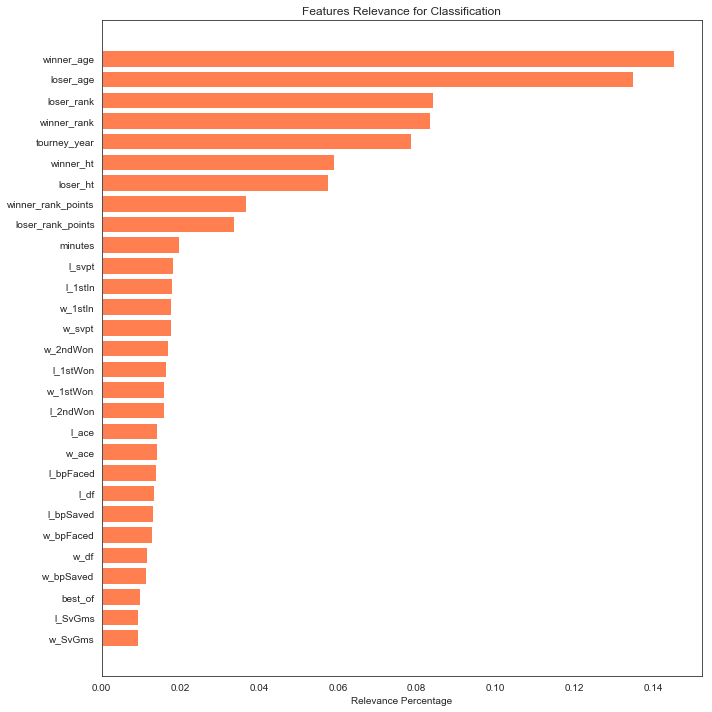

In [69]:
feat_forest = RandomForestClassifier(n_jobs=-1)
feat_forest.fit(X=df_feat.drop("Labels", axis=1), y=df_feat.loc[:, "Labels"])

plt.figure(figsize=(10, 10))
feat_imp = feat_forest.feature_importances_
cols = df_feat.columns

feat_imp, cols = zip(*sorted(zip(feat_imp, cols)))

plt.barh(range(len(cols)), feat_imp, align="center", color='coral');
plt.yticks(range(len(cols)), cols)
plt.title("Features Relevance for Classification")
plt.xlabel("Relevance Percentage")
plt.tight_layout();

plt.savefig('features_relevance.png')
#plotly.offline.plot(fig, filename='features_relevance.html')

In [70]:
relevance_threshold = 0.025 # arbitrary
feat_imp = np.array(feat_imp)
most_relevante_feat = cols[- np.where(feat_imp > relevance_threshold)[0].shape[0] :]

most_relevante_feat

('loser_rank_points',
 'winner_rank_points',
 'loser_ht',
 'winner_ht',
 'tourney_year',
 'winner_rank',
 'loser_rank',
 'loser_age',
 'winner_age')

In [71]:
df_feat_relevant = df_feat[['loser_rank_points', 'winner_rank_points', 'loser_ht', 'winner_ht',
                          'tourney_year', 'winner_rank', 'loser_rank', 'loser_age', 'winner_age','Labels']].copy()
df_feat_relevant.head(5)

,loser_rank_points,winner_rank_points,loser_ht,winner_ht,tourney_year,winner_rank,loser_rank,loser_age,winner_age,Labels
0,16950.0,16950.0,208.0,208.0,1968.0,0,0.0,25.585903,25.535020,0
1,16950.0,16950.0,208.0,208.0,1968.0,0,0.0,25.585903,27.520876,0
2,16950.0,16950.0,208.0,208.0,1968.0,0,0.0,25.585903,16.216290,0
3,16950.0,16950.0,208.0,208.0,1968.0,0,0.0,25.585903,22.264203,1
4,16950.0,16950.0,208.0,208.0,1968.0,0,0.0,25.585903,29.861739,0


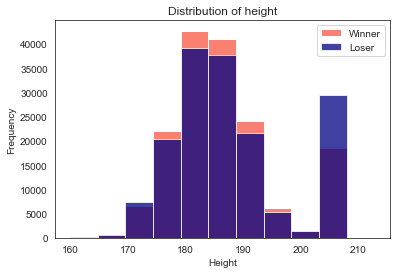

In [73]:
mutual_hist(data1 = df_feat_relevant["winner_ht"].apply(lambda x: x * 1)
                   , data1_name = 'Winner'
                   , data1_color = 'salmon'
                   , data2 = df_feat["loser_ht"].apply(lambda x: x * 1)
                   , data2_name = 'Loser'
                   , data2_color = 'navy'
                   , x_label = 'Height'
                   , y_label = 'Frequency'
                   , title = 'Distribution of height')

display(HTML("<h4>Distribution of height shows that winner height tend to be between 1.75 & 1.95 m. Also, notice the peak at 2.10 which represent NaN value see cell -hypothesis-."))

plt.savefig('Height_winner-loser.png')
#plotly.offline.plot(fig, filename='Height_winner-loser.html')

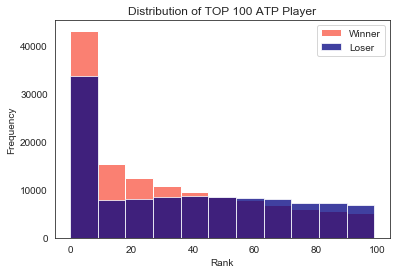

In [74]:
mutual_hist(data1 = df_feat_relevant[df_feat_relevant["winner_rank"] < 100]["winner_rank"]
                   , data1_name = 'Winner'
                   , data1_color = 'salmon'
                   , data2 = df_feat[df_feat["loser_rank"] < 100]["loser_rank"]
                   , data2_name = 'Loser'
                   , data2_color = 'navy'
                   , x_label = 'Rank'
                   , y_label = 'Frequency'
                   , title = 'Distribution of TOP 100 ATP Player')

display(HTML("<h4>Note surprising high ranking players win more than low ranking players. Top 10 peak is high -> to check"))

plt.savefig('rank_winner-loser.png')
#plotly.offline.plot(fig, filename='rank_winner-loser.html')

## Standardize the data

In [75]:
scaler = StandardScaler()

df_feat_relevant = pd.DataFrame(
    scaler.fit_transform(df_feat_relevant.drop(["Labels"], axis=1)),
    columns=most_relevante_feat)

C:\Users\a.mendes\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning:

Data with input dtype float32, int32, float64 were all converted to float64 by StandardScaler.

C:\Users\a.mendes\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\base.py:462: DataConversionWarning:

Data with input dtype float32, int32, float64 were all converted to float64 by StandardScaler.



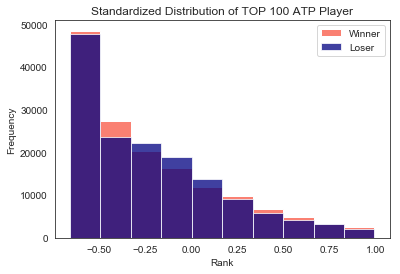

In [76]:
mutual_hist(data1 = df_feat_relevant[df_feat_relevant["winner_rank"] < 1]["winner_rank"]
                   , data1_name = 'Winner'
                   , data1_color = 'salmon'
                   , data2 = df_feat_relevant[df_feat_relevant["loser_rank"] < 1]["loser_rank"]
                   , data2_name = 'Loser'
                   , data2_color = 'navy'
                   , x_label = 'Rank'
                   , y_label = 'Frequency'
                   , title = 'Standardized Distribution of TOP 100 ATP Player')

plt.savefig('standard_rank_winner-loser.png')
#plotly.offline.plot(fig, filename='standard_rank_winner-loser.html')

# Prediction models

## Training

In [77]:
df_feat_relevant = df_feat_relevant.join(df_feat.Labels)
df_feat_relevant = df_feat_relevant.join(df_feat.tourney_year, lsuffix='_caller', rsuffix='_other')

In [78]:
df_feat_relevant[df_feat_relevant.tourney_year_other.isna()]

,loser_rank_points,winner_rank_points,loser_ht,winner_ht,tourney_year_caller,winner_rank,loser_rank,loser_age,winner_age,Labels,tourney_year_other
160636,0.797047,-0.183607,-0.297706,0.952192,1.79636,-0.469098,-0.6363,2.239454,-0.133471,NaN,NaN


In [79]:
df_feat_relevant = df_feat_relevant.dropna()

In [80]:
test_year = 2016.0 # the most recent year

df_train = df_feat_relevant[df_feat_relevant["tourney_year_other"] != test_year]
df_test = df_feat_relevant[df_feat_relevant["tourney_year_other"] == test_year]

X_train = df_train.drop(["Labels"], axis=1)
X_train = X_train.drop(["tourney_year_other"], axis=1)
y_train = df_train["Labels"]

X_test = df_test.drop(["Labels"], axis=1)
X_test = X_test.drop(["tourney_year_other"], axis=1)
y_test = df_test["Labels"]

In [81]:
X_test.head()

,loser_rank_points,winner_rank_points,loser_ht,winner_ht,tourney_year_caller,winner_rank,loser_rank,loser_age,winner_age
160637,-0.275352,0.845624,1.803216,-0.185160,1.79636,-0.565480,-0.523598,-0.825264,2.304573
160638,-0.263285,-0.183607,0.433049,0.952192,1.79636,-0.469098,-0.536857,-0.604916,-0.133471
160639,-0.313968,0.845624,-0.023673,-0.185160,1.79636,-0.565480,-0.470562,-0.240681,2.304573
160640,-0.145828,-0.279860,0.889772,2.192940,1.79636,-0.416526,-0.570005,0.426620,-0.831172
160641,-0.424667,-0.183607,1.803216,0.952192,1.79636,-0.469098,-0.139086,-0.945517,-0.133471


In [82]:
names = ["Nearest Neighbors","Decision Tree", 
         "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "Linear SVM", "RBF SVM"]

classifiers = [
    KNeighborsClassifier(5, n_jobs=-1),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1),
    MLPClassifier(alpha=0.0001),
    AdaBoostClassifier(),
    GaussianNB(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),]

y_pred = []
train_time = []

for name, clf in zip(names, classifiers):
    tic = time()
    clf.fit(X_train, y_train)
    toc = time()
    
    y_pred.append(clf.predict(X_train))
    train_time.append(toc - tic)
    
    print("Classifier : {} ===> Training duration : {} sec".format(name, train_time[-1]))

Classifier : Nearest Neighbors ===> Training duration : 0.147000074387 sec
Classifier : Decision Tree ===> Training duration : 0.518000125885 sec
Classifier : Random Forest ===> Training duration : 0.673000097275 sec


C:\Users\a.mendes\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Classifier : Neural Net ===> Training duration : 93.4049999714 sec
Classifier : AdaBoost ===> Training duration : 4.66799998283 sec
Classifier : Naive Bayes ===> Training duration : 0.047000169754 sec
Classifier : Linear SVM ===> Training duration : 599.707999945 sec
Classifier : RBF SVM ===> Training duration : 3174.36199999 sec


In [108]:
classification_report(y_train, y_pred, names, train_time)

,Classifier,Accuracy,Precision,Recall,F1-Score,Training Duration (seconds)
0,Nearest Neighbors,0.758634,0.757507,0.754977,0.756240,0.147
1,Decision Tree,0.594001,0.573569,0.706799,0.633252,0.518
2,Random Forest,0.636408,0.625079,0.666729,0.645233,0.673
3,Neural Net,0.596454,0.591507,0.602006,0.596710,93.405
4,AdaBoost,0.546789,0.542380,0.551041,0.546676,4.668
5,Naive Bayes,0.515196,0.515883,0.363887,0.426755,0.047
6,Linear SVM,0.512245,0.516390,0.259245,0.345192,599.708
7,RBF SVM,0.756605,0.755241,0.753345,0.754292,3174.362


## Evaluation on test data

In [85]:
y_test_pred = []

for name, clf in zip(names, classifiers):
    y_test_pred.append(clf.predict(X_test))

In [114]:
classification_report(y_test, y_test_pred, names)

,Classifier,Accuracy,Precision,Recall,F1-Score
0,Nearest Neighbors,0.510204,0.508978,0.502729,0.505834
1,Decision Tree,0.511905,0.507848,0.684175,0.582970
2,Random Forest,0.492177,0.489104,0.413370,0.448059
3,Neural Net,0.506122,0.504762,0.506139,0.505450
4,AdaBoost,0.499320,0.497283,0.374488,0.427237
5,Naive Bayes,0.503061,0.509653,0.090041,0.153043
6,Linear SVM,0.503401,0.519737,0.053888,0.097651
7,RBF SVM,0.505442,0.504386,0.470668,0.486944


# Next step

##### 1- Find a better way to fill NaN 
##### 2- Train models with only recent years because old tennis data could be obsolete
##### 3- Increase or decrease the relevance threshold
##### 4- Add Markov chains to train models
##### 5- Try the Decision tree model with futur tournament data and... results/labels
##### 6- Look deeper at data to clean data and/or to exctract new pertinent features
##### 7- Tune models to increase scores prediction
##### 8- Explore new approaches & new models
##### 9- Improve dataviz